# Neural Networks

Reference: [Deep Learning chapter 6](https://www.deeplearningbook.org/contents/mlp.html)

In this course, we have explored different types of function approximators: linear functions, polynomials, support vector machines, radial basis function kernels, etc. Neural networks are another function class that happen to be extremely useful in many machine learning applications. We will introduce neural networks using an example.

## 1. Example: learning XOR

The XOR function takes two binary inputs $x_1$ and $x_2$ and returns $1$ if $(x_1,x_2) = (1,0)$ or $(0,1)$, and returns $0$ if $(x_1,x_2) = (0,0)$ or $(1,1)$. Let's try to learn this function. In this example, the only data is the set of 2-dimensional binary vectors $(0,0), (1,0), (0,1),$ and $(1,1)$. This is used as both the training and test data.

### 1.1 Fit XOR using linear function

First, let's use least squares regression and try to find a linear function to perform the XOR task.

In [211]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0],[1,0],[0,1],[1,1]]) # matrix of inputs
y = np.array([[0],[1],[1],[0]]) # vector of desired outputs
X_augmented = np.hstack((X,np.ones((4,1)))) # add column of 1's for bias feature
w = np.linalg.inv(X_augmented.T@X_augmented)@X_augmented.T@y # Least squares solution for weights
print("weights: ", np.round(w[0:2,0],2))
print("bias: ", np.round(w[-1],2))
print("Predictions: ",(X_augmented@w).flatten())
print("True labels: ",y.flatten())

weights:  [0. 0.]
bias:  [0.5]
Predictions:  [0.5 0.5 0.5 0.5]
True labels:  [0 1 1 0]


The linear least squares estimator outputs a constant value of 0.5 and is unable to represent the XOR function. Could this be due to a poor choice of loss function? What if we tried LASSO instead of least squares regression? 

In this example, the choice of loss function is not the root of the problem. If $x_1 = 0$, then the estimator must be increasing in $x_2$ (as $x_2$ increases from $0$ to $1$, the output must increase from $0$ to $1$). If $x_1 = 1$, then the estimator must be decreasing in $x_2$ (as $x_2$ increases from $0$ to $1$, the output must decrease from $1$ to $0$). However, a linear estimator must choose a constant weight, either positive, negative, or zero, for $x_2$, and cannot have a weight that depends on the value of $x_1$. A linear estimator cannot learn the XOR function.

### 1. 2 Fit XOR using piecewise linear function

Now let's construct a simple nonlinear estimator that can perform the XOR task. First apply an affine transformation to the input data: 

In [212]:
w = np.array([[1],[1]])
Z = X@w # z = x_1 + x_2
print(Z)

[[0]
 [1]
 [1]
 [2]]


From this transformation it's clear we want a function that outputs $0$ when $z = 0$ or $2$, and that outputs $1$ when $z = 1$. This can be accomplished by a simple piecewise linear function:

Inputs:  0 1 2
Predictions:  [0. 1. 0.]


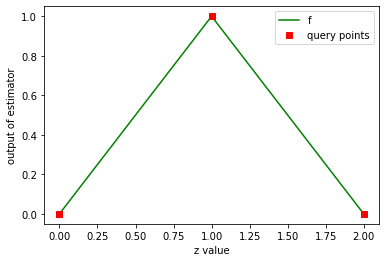

In [213]:
def f(Z): # Define a piecewise linear function
    f = np.zeros(len(Z))
    f[Z <= 1] = Z[Z<=1] # f(z) = z if z <= 1
    f[Z > 1] = 2 - Z[Z > 1] # f(z) = 2-z if z > 1
    return f

# Plot the function:
y_hat = []
Z = np.linspace(0,2,21)
Y_hat = f(Z)
plt.plot(Z,Y_hat,'g',label = 'f')
Z_test = np.array([0,1,2])
plt.plot(Z_test,[0,1,0],'rs',label='query points')
plt.legend()
plt.xlabel('z value')
plt.ylabel('output of estimator')

print("Inputs: ",0,1,2)
print("Predictions: ", f(Z_test))

In other words, the XOR function can be written as $g(x) = f(w^Tx)$, where $w^T = [1 \ 1]$ and $f$ is the piecewise linear function shown in green above. However, this was a simple problem that we were able to solve by inspection. How can we generalize this solution technique to more difficult problems?

### 1.3 Writing piecewise linear function as sum of ReLU functions

The ReLU function, short for rectified linear unit, is given by 

<center> $r(z) = max(0,z).$ </center>

If $z$ is a vector, the ReLU function will act separately on each element of the vector.

What does the ReLU function look like?

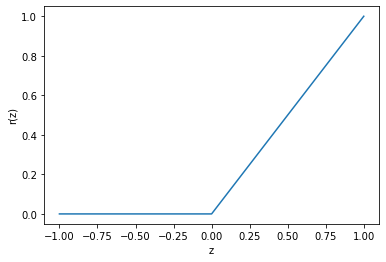

In [214]:
relu = lambda z: np.maximum(0,z) # Use lambda syntax to conveniently define a one line function

z = np.linspace(-1,1,21)
plt.plot(z,relu(z))
plt.xlabel('z')
plt.ylabel('r(z)');

ReLU functions can be combined (using translation, scaling, addition, and function composition) to express piecewise linear functions in a compact, convenient manner. How is this done for the XOR function?

Using ReLUs, we can write $f$ as 

<center> $f(z) = f_1(z) + f_2(z)$, where <center>
    
<center> $f_1(z) = r(z)$ and <center> 
    
<center> $f_2(z) = - 2r(z-1)$.<center>
    
Let's plot $f_1$ and $f_2$:

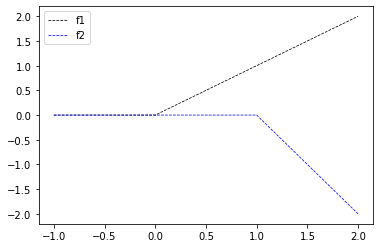

In [215]:
f1 = lambda z: relu(z)
f2 = lambda z: - 2*relu(z - 1)
Z = np.linspace(-1,2,31)
plt.plot(Z,f1(Z),'k--',label='f1',linewidth=.75)
plt.plot(Z,f2(Z),'b--',label='f2',linewidth=.75)
plt.legend();

Now, adding $f_1$ and $f_2$ gives the desired behavior on the interval $[0,2]$. 

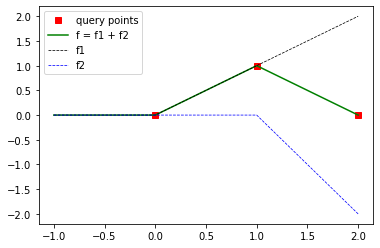

In [216]:
f = lambda z: f1(z) + f2(z)
plt.plot(Z_test,[0,1,0],'rs',label='query points')
plt.plot(Z,f(Z),'g',label='f = f1 + f2')
plt.plot(Z,f1(Z),'k--',label='f1',linewidth=.75)
plt.plot(Z,f2(Z),'b--',label='f2',linewidth=.75)
plt.legend();

### 1.4 Writing sum of ReLU functions using matrix vector notation

Combinations of ReLU functions can be expressed compactly using matrix vector notation. For the XOR example, it looks like this:

In [217]:
W_1 = np.array([[1,1],[1,1]]) # 2 rows each equal to [1 1] since we need 2 copies of z = x_1 + x_2
b_1 = np.array([[0],[-1]])
W_2 = np.array([[1,-2]])
b_2 = np.array([[0]])
g = W_2 @ relu(W_1@X.T + b_1) + b_2
print("See if this works: ")
print("Inputs: \n", X)
print("Outputs: \n ", g.T)

See if this works: 
Inputs: 
 [[0 0]
 [1 0]
 [0 1]
 [1 1]]
Outputs: 
  [[0]
 [1]
 [1]
 [0]]


What exactly is $g$ doing? 

1. Input $x$, a vector in $R^2$
2. Multiply by the matrix $W_1$
3. Add the bias $b_1$
4. Apply the ReLU function elementwise
5. Multiply by the matrix $W_2$
6. Add the bias $b_2$

This fits into a more general framework:

1. Multiply by a weight matrix
2. Add a bias vector
3. Apply a nonlinear "activation" function elementwise
4. Repeat

By following this process, we can construct powerful estimators called neural networks that can represent almost any function.

Note: instead of ReLU, it is possible to use other [activation functions](https://en.wikipedia.org/wiki/Activation_function).

### 1.5 Fit XOR using neural networks and Pytorch

[Pytorch](https://pytorch.org/docs/stable/index.html) is a Python package for machine learning and neural networks. In this class, we will be using it for all programming problems involving neural networks. To introduce Pytorch, we will stick with the current theme and try to learn the XOR function. 

In [233]:
import torch
import torch.nn as nn

# Source: https://pytorch.org/tutorials/beginner/basics/intro.html

The problem data is stored in ```tensors``` which are like numpy arrays but have additional functionality for machine learning applications.

In [234]:
# Problem data:
X = torch.tensor([[0,0],[1,0],[0,1],[1,1]]).float()
Y = torch.tensor([[0],[1],[1],[0]]).float()

Below, we construct a neural network in the Pytorch syntax. The base class is called the Pytorch Module, and neural networks are built on top of these modules. Modules (and neural networks) generally consist of 2 functions, ```__init__``` and ```forward```. The ```__init__``` function sets the structure of the network and ```forward``` evaluates it (takes an input and returns the output of the network). 

In [235]:
# Neural network class:
class XOR_net(nn.Module): 
    def __init__(self):
        super(XOR_net, self).__init__()
        self.model = nn.Sequential( # Define the structure of the network
            nn.Linear(2,2), # First linear layer: 2 inputs and 2 outputs
            nn.ReLU(),
            nn.Linear(2,1), # Second linear layer: 2 inputs, 1 output
        )

    def forward(self, x): 
        return self.model(x)
    
net = XOR_net() # Create the neural network

For the purposes of illustration, we will fix some of the parameters in the network at their desired values. This ensures that the solution the algorithm finds will be the same as the hand-picked solution that we have been working with, since there are infinitely many solutions that correctly perform the XOR task.

In [236]:
# Fix the weights in the first layer and the biases in the last layer:
net.model[0].weight = nn.Parameter(torch.ones_like(net.model[0].weight))
net.model[0].weight.requires_grad=False
net.model[2].bias = None

In order to fit any dataset, we need to define a loss function. For this example, let's stick with the L2 or mean squared error loss. 

In [237]:
# Loss function for training:
loss_fn = nn.MSELoss()

Now that we have a neural network and a loss function, it's time to optimize the weights of the network to fit the data. To accomplish this, we will use gradient descent. In Pytorch, we define an ```optimizer``` which performs the task of adjusting the weights a small amount in the direction of the gradient of the loss function with respect to the weights. The training process is summarized as follows:

1. Use the network to make a prediction for each training example
2. Compute the loss associated with these predictions
3. Compute the gradient of the training loss with respect to the neural network parameters
4. Update the parameters of the network by taking a small step in the direction of the gradient
5. Repeat until the loss stops improving, or until a certain number of iterations is reached

In [238]:
# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []

# Function that performs one iteration of gradient descent to improve the model parameters:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step

We are finally ready to train the network.

Predictions: 
 [[0.]
 [1.]
 [1.]
 [0.]]
Weights:
W_1 = 
  [[1. 1.]
 [1. 1.]]
b_1 = 
 [ 0. -1.]
W_2 = 
 [[ 1. -2.]]


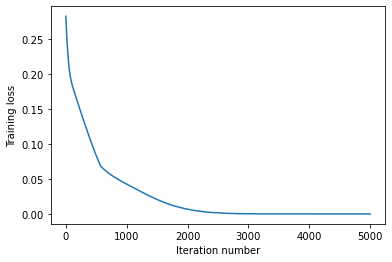

In [239]:
T = 5000 # Set maximum number of iterations
for t in range(T):
    train_loop(net,loss_fn,optimizer,X,Y) # Take a gradient step
    
print("Predictions: \n", np.round(net(X).detach().numpy(),2))
print("Weights:")
print("W_1 = \n ", net.model[0].weight[:,:].detach().numpy())
print("b_1 = \n", np.round(net.model[0].bias[:].detach().numpy(),2))
print("W_2 = \n",np.round(net.model[2].weight[:,:].detach().numpy(),2))

plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

In summary, neural networks provide a way to generate functions with complex behavior by combining elementary "building blocks" or nonlinear activation functions. Let's extend this technique to some examples in power sytems.

## 2. Example: fault detection in power systems

In order to understand how a power system is functioning, we need to know 4 quantities at each bus:
* Real power injection
* Reactive power injection
* Voltage magnitude
* Voltage angle

In the event that a transmission line goes down, these quantities will change, indicating that something has happened. In this example, we consider a power system with 30 buses. 10 of the buses are equipped with [phasor measurement units](https://en.wikipedia.org/wiki/Phasor_measurement_unit) that allow us to measure the voltage angle in real time. The task is to measure the voltage angles at the ten buses and to determine whether a fault has occurred.

The data consists of observations ```X``` and labels ```Y```. Each row of ```X``` consists of a set of voltage angle measurements at the 10 buses under observation. The labels take on binary values, with 0 corresponding to no fault and 1 corresponding to the presence of a fault when the measurement was taken.

In [240]:
# Load data and split into training and test sets

XY = np.loadtxt('fault_detection_data.txt')

M = np.shape(XY)[0] # Size of dataset
n = int(.8*M) # Size of training set
X_train = XY[0:n,0:-1]
Y_train = XY[0:n,-1]
X_test = XY[n:,0:-1]
Y_test = XY[n:,-1]

First, let's train a linear classifier to detect faults based on voltage measurements.

In [241]:
# Train a linear classifier for comparison

from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train,Y_train)
Y_hat_train = logistic_classifier.predict(X_train)
print("Training error rate: ", np.sum(np.abs(Y_train-Y_hat_train))/n)
Y_hat_test = logistic_classifier.predict(X_test)
print("Test error rate: ", np.sum(np.abs(Y_test-Y_hat_test))/(M-n))

Training error rate:  0.375
Test error rate:  0.38333333333333336


The test error rate is 38%. Let's see if a neural network can do better. 

Training error rate:  0.004166666666666667
Test error rate:  0.26666666666666666


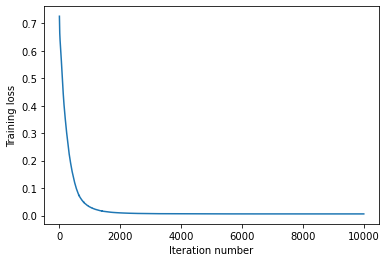

In [242]:
# Convert data from numpy array to pytorch tensor:
X_train_torch = torch.tensor(X_train).float()
Y_train_torch = torch.tensor(Y_train).float()
X_test_torch = torch.tensor(X_test).float()
Y_test_torch = torch.tensor(Y_test).float()

n_pmu = X_train.shape[1]

# Neural network class:
class fault_net(nn.Module): 
    def __init__(self,n_hidden): # Passing the parameter n_hidden to the __init__ function allows us to customize the width of the network
        super(fault_net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pmu,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1),
        )

    def forward(self, x): 
        return torch.sigmoid(self.model(x)) # Sigmoid clamps the output between 0 and 1 for binary classification
    
# Loss function for training:
loss_fn = nn.BCELoss() # Same loss function as for logistic regression

n_hidden = 64 # The width of each hidden layer in the network
net = fault_net(n_hidden) # Create neural network of width n_hidden

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 10000
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch,Y_train_torch.unsqueeze(1))
    
Y_hat_train = torch.round(net(X_train_torch)) # Round predictions to 0 or 1
Y_hat_test = torch.round(net(X_test_torch))
print("Training error rate: ", torch.sum(torch.abs(Y_train_torch-Y_hat_train.flatten())).item()/n)
print("Test error rate: ", torch.sum(torch.abs(Y_test_torch-Y_hat_test.flatten())).item()/(M-n))
plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

## 3. Example: state estimation

In Homework 2, we looked at the problem of estimating the voltage angles in a power grid, given line flow and bus injection measurements. Let's revisit this example using neural networks. In this problem, we will try to estimate voltage angles using only power injection measurements.

In [243]:
# Load data and split into training and test sets

XY = np.loadtxt('state_estimation_data.txt')

nbus = 30

M = np.shape(XY)[0] # Size of dataset
n = int(.8*M) # Size of training set
X_train = XY[0:n,0:nbus]
Y_train = XY[0:n,nbus:]
X_test = XY[n:,0:nbus]
Y_test = XY[n:,nbus:] # Note that there are 30 columns in X but only 29 columns in Y. That's because the voltage angle at the reference bus is always assumed to be 0, so we don't need to predict it.

First, let's check the performance of a linear model:

In [244]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
W = np.zeros((nbus,nbus-1))
b = np.zeros((nbus-1))

for i in range(nbus-1): # Get seperate column of weights for each angle measurement (skip slack bus)
    linear_regressor.fit(X_train,Y_train[:,i])
    W[:,i] = linear_regressor.coef_
    b[i] = linear_regressor.intercept_
    
Y_hat_train = X_train@W + b
Y_hat_test = X_test@W + b
print("Training error: ", np.linalg.norm(Y_hat_train-Y_train,'fro')**2/n)
print("Test error: ", np.linalg.norm(Y_hat_test-Y_test,'fro')**2/(M-n))

Training error:  0.31710994169875123
Test error:  0.8971148005248587


Now, for a neural network:

Training error:  0.08762215822935104
Test error:  14.269968032836914


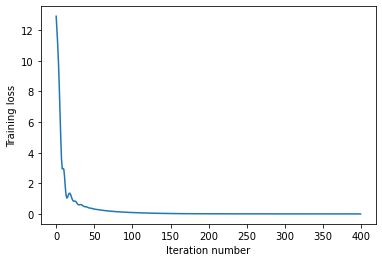

In [245]:
X_train_torch = torch.tensor(X_train).float()
Y_train_torch = torch.tensor(Y_train).float()
X_test_torch = torch.tensor(X_test).float()
Y_test_torch = torch.tensor(Y_test).float()

# Neural network class:
class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 256
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus-1),
        )

    def forward(self, x): 
        return self.model(x)
    
# Loss function for training:
loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 400
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch,Y_train_torch)
    
Y_hat_train = net(X_train_torch)
Y_hat_test = net(X_test_torch)
print("Training error: ", (torch.linalg.norm(Y_hat_train-Y_train_torch,ord='fro')**2/n).item())
print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

In this example, the neural network performs substantially better on the training dataset and substantially worse on the test dataset. This is an example of _overfitting_.

# Homework questions

## Problem 1: Hyperparameter selection

Modify the example code from the fault detection problem to include a hyperparameter tuning routine. Your code should:
* Randomly generate values for ```n_hidden``` (the width of each hidden layer in the neural network) and ```lr``` (learning rate)
* Create a network of width ```n_hidden``` and an optimizer with learning rate ```lr```
* Train the network and record the hyperparemeters and the test error
* Repeat

Plot the test error vs. iteration number. Also plot the best test error seen up to that point in the hyperparemeter training process vs. iteration number.

In [ ]:
# insert your code here

## Problem 2: Stochastic gradient descent

In the above examples, we trained the neural networks using gradient descent. [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) is a different algorithm for optimizing the parameters of a neural network. In SGD, we only consider one or a few training samples per iteration, instead of using the entire training dataset. By considering only a few data points at a time, the algorithm will take a less direct path towards the optimum. However, the approach is popular because it is faster to execute each training iteration.

For this problem, modify the example code from the state estimation problem to implement SGD. For each iteration, the function ```train_loop``` should:
* Randomly select a subset of the rows of ```X_train``` and ```Y_train``` (called a "minibatch")
    * Hint: use ```torch.randint``` to randomly generate row numbers.
* Use the neural network to make predictions on the minibatch
* Evalutate the loss associated with these predictions
* Take a step in the direction of the gradient of the minibatch loss

Plot the training loss as a function of the iteration number. How do the batch size and learning rate affect the results?

In [ ]:
# insert your code here